## Overview of M_AE, T_AE and E_AE single autoencoders

Here we present the results of building T_only, E_only and M_only autoencoders. 

In [1]:
import seaborn as sns
import re
import os
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import cplAE_MET.utils.utils as ut
import cplAE_MET.utils.plots as utplt
from cplAE_MET.utils.dataset import  load_MET_dataset, MET_data_summary

# This is used to be able to run the notebook both remote and locally
Allen_dir = "/allen/programs/celltypes/workgroups/rnaseqanalysis/Fahimehb/git_workspace/cplAE_MET/data/"
remote_dir = "/Users/fahimehb/Documents/git-workspace/cplAE_MET/data/"

parent_dir = Allen_dir

/allen/programs/celltypes/workgroups/rnaseqanalysis/Fahimehb/miniconda3/envs/cplmet/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# some functions
def get_1D_mask(x):
    mask = ~np.isnan((x))
    mask = mask.reshape(mask.shape[0], -1)
    return np.all(mask, axis=1)

def plot_arbor_densities(M_data, cell):
    fig, ax = plt.subplots(1,4, figsize=(25,7))
    sns.heatmap(M_data[cell,:,:,0], ax=ax[0], cbar=True) 
    sns.heatmap(M_data[cell,:,:,1], ax=ax[1], cbar=True)
    sns.heatmap(M_data[cell,:,:,2], ax=ax[2], cbar=True)
    sns.heatmap(M_data[cell,:,:,3], ax=ax[3], cbar=True)
    ax[0].set_title("axon")
    ax[1].set_title("dendrite")
    ax[2].set_title("apical")
    ax[3].set_title("basal")
    plt.show()  

In [3]:
MET_data = load_MET_dataset(parent_dir + "proc/MET_data_16Feb22.mat")
MET_data_summary(MET_data)

T shape (5468, 1252)
E shape (5468, 134)
M shape (5468, 120, 4, 4)
sd shape (5468,)

Paired samples, allowing for nans in some features
5322 cells paired in T and E
1454 cells paired in T and M
1399 cells paired in E and M

Paired samples, without nans in any feature (strict)
5322 cells paired in T and E
1454 cells paired in T and M
1399 cells paired in E and M


## Input data

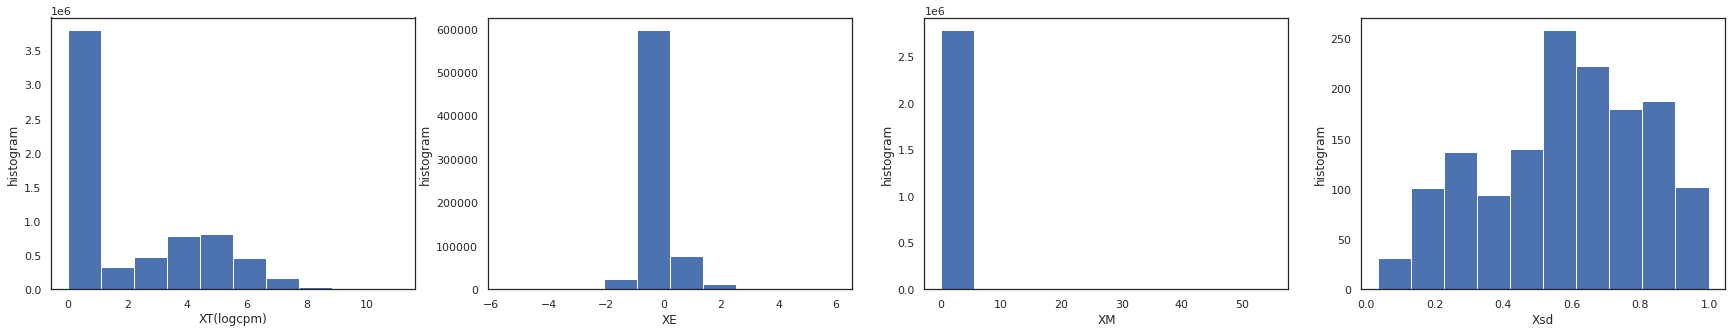

In [4]:
fig, axs = plt.subplots(1,4, figsize=(30, 5))
var = [MET_data['XT'].flatten(), MET_data['XE'].flatten(), MET_data['XM'].flatten(), MET_data['Xsd'].flatten()]
current_label = ["XT(logcpm)", "XE", "XM", "Xsd"]
for i, ax in enumerate(axs):
    ax.hist(var[i])
    ax.set_xlabel(current_label[i])
    ax.set_ylabel("histogram")


#### Arbor densities

L5 PT VISp C1ql2 Cdh13    


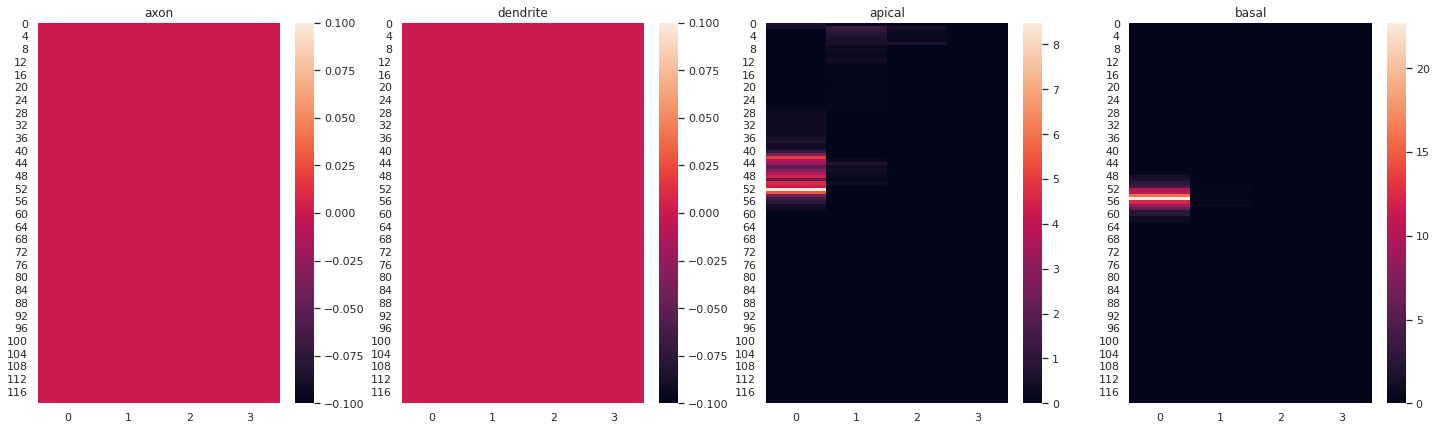

In [5]:
# create the mask for M data
M_mask = get_1D_mask(MET_data['XM'])

# M_data
M_data = MET_data['XM'][M_mask]

# plot arbor densities for a random cell
# if it is exc, then it has apical and basal otherwise it has axon and dend
cell = np.random.randint(0, M_data.shape[0],1)[0]
print(MET_data['cluster_label'][M_mask][cell])
plot_arbor_densities(M_data=M_data, cell=cell)

## Building a T autoencoder

In [6]:
def get_exit_summary_keys(listdir):
    '''
    Get list of exit_summary files in a folder and return the hyperparameters used in the run
    Args:
        listdir:

    Returns:

    '''
    vars = []
    for f in listdir:
        if f.endswith(".pkl"):
            model_id = re.search('summary_(.*)_ld_',f).group(1)
            ld = re.search('ld_(.*)_ne_', f).group(1)
            fold = re.search('fold_(.*).pkl',f).group(1)
            vars.append((model_id, ld, fold))
    return vars

def get_exit_summary_df(dir, file_keys):
    '''
    takes the path of the files and find the hyperparam values of each run and return them in a datafram format
    Args:
        dir:
        file_keys:

    Returns:

    '''
    output = {}
    df = pd.DataFrame(columns=["model_id", "ld", "fold", "classification_acc"])
    for var in file_keys:
        fileid = "exit_summary_" + var[0] + "_ld_" + str(var[1]) + "_ne_50000_ri_0_fold_" + str(var[2]) + ".pkl"
        path = dir + fileid
        output[var] = ut.loadpkl(path)
        df1 = pd.DataFrame({'model_id': [var[0]], "ld": [var[1]], "fold": [var[2]], "classification_acc": [output[var]['classification_acc']]})
        df = pd.concat([df, df1], ignore_index=True)
    return output, df
    
def summarize_folder(path):
    '''
    Take the path and return the output of all the runs as a dict and the hyperparams as a dataframe
    Args:
        path:
    Returns:

    '''
    files = os.listdir(path)
    keys = get_exit_summary_keys(files)
    output, df = get_exit_summary_df(path, keys)
    return output, df

In [7]:
T_AE_path = "/allen/programs/celltypes/workgroups/rnaseqanalysis/Fahimehb/git_workspace/cplAE_MET/data/results/DEBUG/T_AE/"
T_AE_output, df = summarize_folder(T_AE_path)
df['ld'] = df['ld'].astype(np.int64)
df.head()

,model_id,ld,fold,classification_acc
0,T_AE,20,8,80.438757
1,T_AE,5,5,68.372943
2,T_AE,10,7,76.965265
3,T_AE,20,0,79.159049
4,T_AE,3,1,59.780622


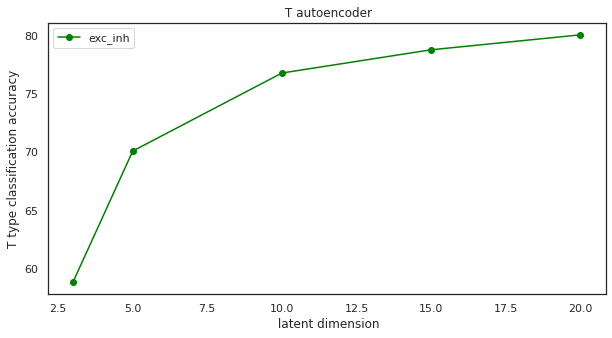

In [8]:
res = df.groupby(["ld"], as_index=False)['classification_acc'].mean().sort_values("ld")
plt.figure(figsize=(10,5))
plt.plot(res['ld'], res['classification_acc'], 'o-', label = "exc_inh", color="green")

plt.title(" T autoencoder")
plt.xlabel(" latent dimension")
plt.ylabel("T type classification accuracy")
plt.legend()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


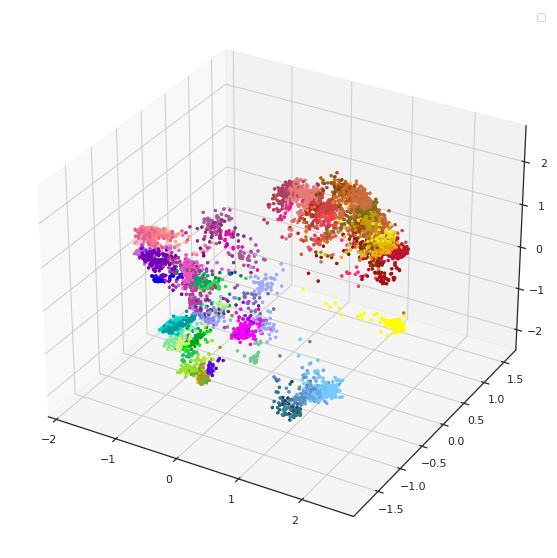

In [9]:
out = T_AE_output[('T_AE', '3', '8')]
utplt.plot_multiple_embeddings(out['z'],
    out['z'], 
    figsize=(10,10),
    plot_dim=3, 
    left_color=out['cluster_color'],
    right_color=out['cluster_color'],
    left_marker='o',
    right_marker='o',
    side_by_side=False,
    scatter_point_size=5)

## Building an E autoencoder

In [10]:
E_AE_path = "/allen/programs/celltypes/workgroups/rnaseqanalysis/Fahimehb/git_workspace/cplAE_MET/data/results/DEBUG/E_AE/"
E_AE_output, df = summarize_folder(E_AE_path)
df['ld'] = df['ld'].astype(np.int64)
df.drop(columns=["fold"]).head()

,model_id,ld,classification_acc
0,E_AE,10,43.327239
1,E_AE,20,49.177331
2,E_AE,20,47.897623
3,E_AE,10,43.69287
4,E_AE,3,23.21755


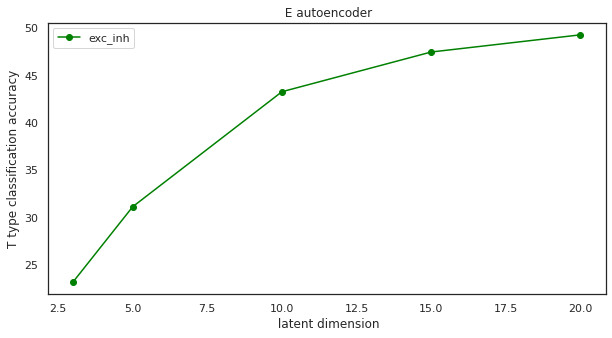

In [11]:
res = df.groupby(["ld"], as_index=False)['classification_acc'].mean().sort_values("ld")
plt.figure(figsize=(10,5))
plt.plot(res['ld'], res['classification_acc'], 'o-', label = "exc_inh", color="green")

plt.title(" E autoencoder")
plt.xlabel(" latent dimension")
plt.ylabel("T type classification accuracy")
plt.legend()

## Building M autoencoder

In [12]:
output, df = summarize_folder("/allen/programs/celltypes/workgroups/rnaseqanalysis/Fahimehb/git_workspace/cplAE_MET/data/results/DEBUG/image_120x4x4/")
res = df.groupby(["model_id", "ld"])['classification_acc'].mean().reset_index()
res['ld'] = res.ld.astype(int)
res.head()

,model_id,ld,classification_acc
0,exc_aM_1-0_asd_1-0_noise_0-0_dilate_0_scale_0-3,10,40.500
1,exc_aM_1-0_asd_1-0_noise_0-0_dilate_0_scale_0-3,15,44.875
2,exc_aM_1-0_asd_1-0_noise_0-0_dilate_0_scale_0-3,20,46.375
3,exc_aM_1-0_asd_1-0_noise_0-0_dilate_0_scale_0-3,3,31.500
4,exc_aM_1-0_asd_1-0_noise_0-0_dilate_0_scale_0-3,5,38.625


In [13]:
res['model'] = res['model_id'].apply(lambda x: re.search('(.*)_aM_',x).group(1))
res.head()

,model_id,ld,classification_acc,model
0,exc_aM_1-0_asd_1-0_noise_0-0_dilate_0_scale_0-3,10,40.500,exc
1,exc_aM_1-0_asd_1-0_noise_0-0_dilate_0_scale_0-3,15,44.875,exc
2,exc_aM_1-0_asd_1-0_noise_0-0_dilate_0_scale_0-3,20,46.375,exc
3,exc_aM_1-0_asd_1-0_noise_0-0_dilate_0_scale_0-3,3,31.500,exc
4,exc_aM_1-0_asd_1-0_noise_0-0_dilate_0_scale_0-3,5,38.625,exc


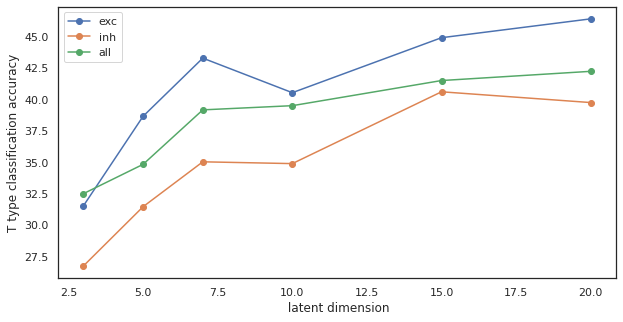

In [14]:
res = res.sort_values('ld')
plt.figure(figsize=(10,5))
plt.plot(res[res['model']=="exc"]['ld'],res[res['model']=="exc"]['classification_acc'], 'o-', label = "exc")
plt.plot(res[res['model']=="inh"]['ld'],res[res['model']=="inh"]['classification_acc'], 'o-', label = "inh")
plt.plot(res[res['model']=="inh_exc"]['ld'],res[res['model']=="inh_exc"]['classification_acc'], 'o-', label = "all")

plt.xlabel(" latent dimension")
plt.ylabel("T type classification accuracy")
plt.legend()